# PySpark ML - Regression

Next you'll learn to create Linear Regression models. You'll also find out how to augment your data by engineering new predictors as well as a robust approach to selecting only the most relevant predictors.

## Preparing the environment

### Importing libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from environment import SEED, histogram_boxplot
from pyspark.sql.types import (StructType, StructField,
                               DoubleType, IntegerType, StringType)
from pyspark.sql import SparkSession, functions as F
from pyspark.mllib.linalg import DenseVector, SparseVector
from pyspark.ml.feature import (OneHotEncoder, StringIndexer, VectorAssembler,
                                Bucketizer)
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark_dist_explore import hist

### Connect to Spark

In [2]:
spark = (SparkSession.builder
                     .master('local[*]') \
                     .appName('spark_application') \
                     .config("spark.sql.repl.eagerEval.enabled", True)  # eval DataFrame in notebooks
                     .getOrCreate())

sc = spark.sparkContext
print(f'Spark version: {spark.version}')

Spark version: 3.5.1


## Loading data

### Flights

In [3]:
# Reading the file
schema_flights = StructType([
    StructField("mon", IntegerType()),
    StructField("dom", IntegerType()),
    StructField("dow", IntegerType()),
    StructField("carrier", StringType()),
    StructField("flight", IntegerType()),
    StructField("org", StringType()),
    StructField("mile", IntegerType()),
    StructField("depart", DoubleType()),
    StructField("duration", IntegerType()),
    StructField("delay", IntegerType())
])
flights_data = spark.read.csv('data-sources/flights.csv', header=True, schema=schema_flights, nullValue='NA')

# Cleaning and mutating some columns
flights_data = flights_data.dropna()
flights_data = flights_data.withColumn('km', F.round(flights_data['mile'] * 1.60934, 0))

# Reviewing the result
flights_data.createOrReplaceTempView("flights")
print(f'Dataframe shape: ({flights_data.count()}, {len(flights_data.columns)})')
flights_data.printSchema()
flights_data.limit(2)

Dataframe shape: (47022, 11)
root
 |-- mon: integer (nullable = true)
 |-- dom: integer (nullable = true)
 |-- dow: integer (nullable = true)
 |-- carrier: string (nullable = true)
 |-- flight: integer (nullable = true)
 |-- org: string (nullable = true)
 |-- mile: integer (nullable = true)
 |-- depart: double (nullable = true)
 |-- duration: integer (nullable = true)
 |-- delay: integer (nullable = true)
 |-- km: double (nullable = true)



mon,dom,dow,carrier,flight,org,mile,depart,duration,delay,km
0,22,2,UA,1107,ORD,316,16.33,82,30,509.0
2,20,4,UA,226,SFO,337,6.17,82,-8,542.0


### SMS

In [4]:
# Reading the file
schema_sms = StructType([
    StructField("id", IntegerType()),
    StructField("text", StringType()),
    StructField("label", IntegerType())
])
sms_data = spark.read.csv("data-sources/sms.csv", sep=';', header=False, schema=schema_sms)

# Reviewing the result
sms_data.createOrReplaceTempView("sms")
print(f'Dataframe shape: ({sms_data.count()}, {len(sms_data.columns)})')
sms_data.printSchema()
sms_data.limit(2)

Dataframe shape: (5574, 3)
root
 |-- id: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)



id,text,label
1,"Sorry, I'll call ...",0
2,Dont worry. I gue...,0


### Cars

In [5]:
# Reading the file
schema_cars = StructType([
    StructField("maker", StringType()),
    StructField("model", StringType()),
    StructField("origin", StringType()),
    StructField("type", StringType()),
    StructField("cyl", IntegerType()),
    StructField("size", DoubleType()),
    StructField("weight", IntegerType()),
    StructField("length", DoubleType()),
    StructField("rpm", IntegerType()),
    StructField("consumption", DoubleType())
])
cars_data = spark.read.csv('data-sources/cars.csv', header=True, schema=schema_cars, nullValue='NA')

# Cleaning and mutating some columns
cars_data = cars_data.dropna()
cars_data = cars_data.withColumn('mass', F.round(cars_data.weight / 2.205, 0))
cars_data = cars_data.withColumn('length', F.round(cars_data.length * 0.0254, 3))
cars_data = cars_data.withColumn('consumption', F.round(cars_data.consumption * 3.78541, 3))

# Reviewing the result
cars_data.createOrReplaceTempView("cars")
print(f'Dataframe shape: ({cars_data.count()}, {len(cars_data.columns)})')
cars_data.printSchema()
cars_data.limit(2)

Dataframe shape: (92, 11)
root
 |-- maker: string (nullable = true)
 |-- model: string (nullable = true)
 |-- origin: string (nullable = true)
 |-- type: string (nullable = true)
 |-- cyl: integer (nullable = true)
 |-- size: double (nullable = true)
 |-- weight: integer (nullable = true)
 |-- length: double (nullable = true)
 |-- rpm: integer (nullable = true)
 |-- consumption: double (nullable = true)
 |-- mass: double (nullable = true)



maker,model,origin,type,cyl,size,weight,length,rpm,consumption,mass
Geo,Metro,non-USA,Small,3,1.0,1695,3.835,5700,7.571,769.0
Honda,Civic,non-USA,Small,4,1.5,2350,4.394,5900,8.214,1066.0


### Books

In [6]:
# Reading the file
schema_books = StructType([
    StructField("id", IntegerType()),
    StructField("text", StringType())
])
books_data = spark.read.csv("data-sources/books.csv", sep=';', header=True, schema=schema_books)

# Reviewing the result
books_data.createOrReplaceTempView("books")
print(f'Dataframe shape: ({cars_data.count()}, {len(cars_data.columns)})')
books_data.printSchema()
books_data.limit(2)

Dataframe shape: (92, 11)
root
 |-- id: integer (nullable = true)
 |-- text: string (nullable = true)



id,text
0,"Forever, or a Lon..."
1,Winnie-the-Pooh


### BMI

In [7]:
# Reading the file
schema_bmi = StructType([
    StructField("height_mt", DoubleType()),
    StructField("mass_kg", DoubleType())
])
bmi_data = spark.read.csv("data-sources/bmi.csv", sep=',', header=True, schema=schema_bmi)

# Reviewing the result
bmi_data.createOrReplaceTempView("bmi")
print(f'Dataframe shape: ({cars_data.count()}, {len(cars_data.columns)})')
bmi_data.printSchema()
bmi_data.limit(2)

Dataframe shape: (92, 11)
root
 |-- height_mt: double (nullable = true)
 |-- mass_kg: double (nullable = true)



height_mt,mass_kg
1.7496714153011232,54.45891245893144
1.6861735698828815,63.856884442309884


### Tables catalogue

In [8]:
spark.catalog.listTables()

[Table(name='bmi', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='books', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='cars', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='flights', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='sms', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True)]

## Others

### Dense versus sparse

In [9]:
print(f'''
 Dense vector: {DenseVector([1, 0, 0, 0, 0, 7, 0, 0])}
Sparse vector: {SparseVector(8, {0: 1.0, 5: 7.0})}
''')


 Dense vector: [1.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0]
Sparse vector: (8,[0,5],[1.0,7.0])



# Cars Dataset

### Loading data - Flights

In [10]:
# Reviewing the data
df_cars = cars_data
df_cars.groupBy('type').count().sort(F.col("count").desc()).show()
df_cars.limit(2)

+-------+-----+
|   type|count|
+-------+-----+
|Midsize|   22|
|  Small|   21|
|Compact|   16|
| Sporty|   13|
|  Large|   11|
|    Van|    9|
+-------+-----+



maker,model,origin,type,cyl,size,weight,length,rpm,consumption,mass
Geo,Metro,non-USA,Small,3,1.0,1695,3.835,5700,7.571,769.0
Honda,Civic,non-USA,Small,4,1.5,2350,4.394,5900,8.214,1066.0


## One-Hot Encoding

### One-hot encoding

In [11]:
df_cars = df_cars.drop(*['type_idx', 'type_vec'])

# Assign index values to strings
indexer_cars = StringIndexer(inputCol='type', outputCol='type_idx').fit(df_cars)

# Create column with index values
df_cars = indexer_cars.transform(df_cars)

# Initialize the encoder
onehot_cars = OneHotEncoder(inputCols=['type_idx'], outputCols=['type_vec']).fit(df_cars)
print(f"How many category levels? {onehot_cars.categorySizes}")

# Vectorize the index values
df_cars = onehot_cars.transform(df_cars)

# Inspect results
df_cars.select('type', 'type_idx', 'type_vec').distinct().sort('type_idx').show()
df_cars.limit(2)

How many category levels? [6]
+-------+--------+-------------+
|   type|type_idx|     type_vec|
+-------+--------+-------------+
|Midsize|     0.0|(5,[0],[1.0])|
|  Small|     1.0|(5,[1],[1.0])|
|Compact|     2.0|(5,[2],[1.0])|
| Sporty|     3.0|(5,[3],[1.0])|
|  Large|     4.0|(5,[4],[1.0])|
|    Van|     5.0|    (5,[],[])|
+-------+--------+-------------+



maker,model,origin,type,cyl,size,weight,length,rpm,consumption,mass,type_idx,type_vec
Geo,Metro,non-USA,Small,3,1.0,1695,3.835,5700,7.571,769.0,1.0,"(5,[1],[1.0])"
Honda,Civic,non-USA,Small,4,1.5,2350,4.394,5900,8.214,1066.0,1.0,"(5,[1],[1.0])"


In [12]:
# Getting the encoded values from the catego column
colIdx = df_cars.select('type', "type_idx").distinct().rdd.collectAsMap()
colIdx =  sorted((value, key) for (key, value) in colIdx.items())
newCols_type = list(map(lambda x: x[1], colIdx))
print(f'''
Category level: {len(newCols_type)}
Encoded without the last catego: {newCols_type[:-1]}
Dropped catego: {newCols_type[-1]}
''')


Category level: 6
Encoded without the last catego: ['Midsize', 'Small', 'Compact', 'Sporty', 'Large']
Dropped catego: Van



## Regression

### Consumption versus mass: scatter

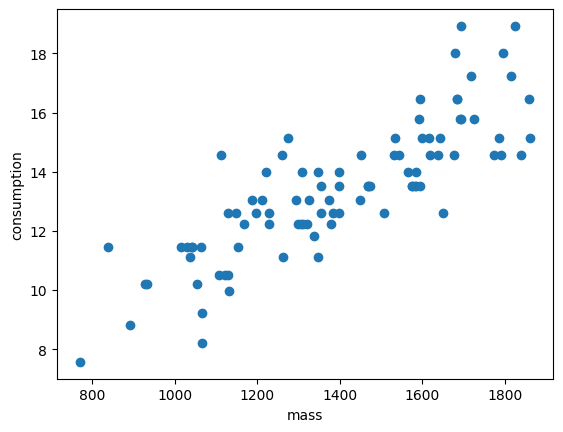

In [13]:
df_cars_pandas = df_cars.toPandas()
plt.scatter(df_cars_pandas.mass, df_cars_pandas.consumption)
plt.xlabel('mass')
plt.ylabel('consumption')
plt.show()

### Assemble predictors

In [14]:
df_cars = df_cars.drop(*['features'])

feature_cols = ['mass', 'cyl', 'type_vec']
assembler_cars = VectorAssembler(inputCols=feature_cols, outputCol='features')
df_cars = assembler_cars.transform(df_cars)
df_cars.select(feature_cols + ['features', 'consumption']).show(5, truncate=False)

+------+---+-------------+----------------------------+-----------+
|mass  |cyl|type_vec     |features                    |consumption|
+------+---+-------------+----------------------------+-----------+
|769.0 |3  |(5,[1],[1.0])|(7,[0,1,3],[769.0,3.0,1.0]) |7.571      |
|1066.0|4  |(5,[1],[1.0])|(7,[0,1,3],[1066.0,4.0,1.0])|8.214      |
|891.0 |3  |(5,[1],[1.0])|(7,[0,1,3],[891.0,3.0,1.0]) |8.82       |
|1066.0|4  |(5,[1],[1.0])|(7,[0,1,3],[1066.0,4.0,1.0])|9.236      |
|1132.0|4  |(5,[1],[1.0])|(7,[0,1,3],[1132.0,4.0,1.0])|9.956      |
+------+---+-------------+----------------------------+-----------+
only showing top 5 rows



### Split into testing and training sets

In [15]:
# Split into train and test set.
df_cars_train, df_cars_test = df_cars.randomSplit([0.8, 0.2], seed=SEED)
[df_cars_train.count(), df_cars_test.count()]

[75, 17]

### Build regression model

In [16]:
model_lr_cars = LinearRegression(labelCol='consumption').fit(df_cars_train)

# Predict on cars_test (testing data).
predictions_cars = model_lr_cars.transform(df_cars_test)
predictions_cars.select('consumption', 'prediction').show(12)

+-----------+------------------+
|consumption|        prediction|
+-----------+------------------+
|     14.574| 14.26220817543322|
|     13.514|13.662036309323547|
|     15.142|   14.935791515778|
|     14.574|15.291994228320064|
|     13.514|13.750491531993994|
|      11.47|10.942086016194082|
|     13.514|13.701841159525248|
|     12.605|12.508578788387748|
|     11.129|11.654985889617926|
|     14.006|12.468608094496371|
|     17.224| 16.20618213490983|
|     16.467| 14.48334623210934|
+-----------+------------------+
only showing top 12 rows



### Examine predictions

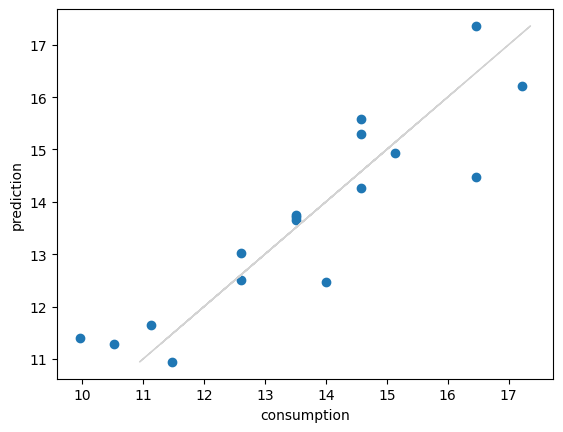

In [17]:
df_cars_pandas = predictions_cars.toPandas()
plt.scatter(df_cars_pandas.consumption, df_cars_pandas.prediction)
plt.xlabel('consumption')
plt.ylabel('prediction')
plt.plot(df_cars_pandas.prediction, df_cars_pandas.prediction, lw=1, color='lightgray')
plt.show()

### Calculate RMSE

In [18]:
# Select columns to compute test error
eval_cars = RegressionEvaluator(labelCol='consumption')

print(f'''
RMSE: {eval_cars.evaluate(predictions_cars)}
 MAE: {eval_cars.evaluate(predictions_cars, {eval_cars.metricName: "mae"})}
  R²: {eval_cars.evaluate(predictions_cars, {eval_cars.metricName: "r2"})}
 MSE: {eval_cars.evaluate(predictions_cars, {eval_cars.metricName: "mse"})}
''')


RMSE: 0.8852987870756852
 MAE: 0.7074495911938732
  R²: 0.8105462852852755
 MSE: 0.7837539423976794



### Consumption versus mass: intercept

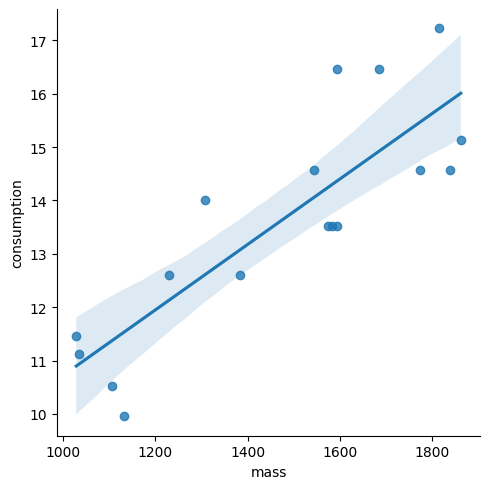

In [19]:
df_cars_pandas = predictions_cars.toPandas()
sns.lmplot(x='mass', y='consumption', data=df_cars_pandas, fit_reg=True) 
plt.show()

### Examine intercept & Coefficients

In [20]:
print(f'''
Intercept: {model_lr_cars.intercept}
Coefficients:
{model_lr_cars.coefficients}

Feature cols: {feature_cols}
Encoded categos (type_vec): {newCols_type[:-1]}
''')


Intercept: 7.658292748160934
Coefficients:
[0.0044227611335224066,0.3749142267127804,-2.474313123162991,-2.76688484521253,-2.249252292961028,-2.084944299723345,-3.20716782327834]

Feature cols: ['mass', 'cyl', 'type_vec']
Encoded categos (type_vec): ['Midsize', 'Small', 'Compact', 'Sporty', 'Large']



In [21]:
# With more detail
coefficient_len = len(model_lr_cars.coefficients)
pd.DataFrame({
    'Slope': ['Intercept'] + ['Coefficients']*coefficient_len,
    'Feature': [''] + feature_cols[:-1] + newCols_type[:-1],
    'value': [model_lr_cars.intercept] + list(model_lr_cars.coefficients)
})

,Slope,Feature,value
0,Intercept,,7.658293
1,Coefficients,mass,0.004423
2,Coefficients,cyl,0.374914
3,Coefficients,Midsize,-2.474313
4,Coefficients,Small,-2.766885
5,Coefficients,Compact,-2.249252
6,Coefficients,Sporty,-2.084944
7,Coefficients,Large,-3.207168


## Bucketing & Engineering

### RPM histogram

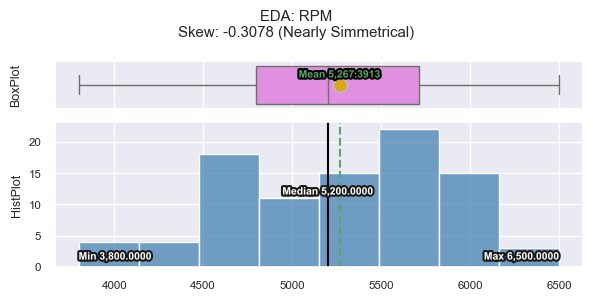

In [22]:
histogram_boxplot(df_cars.select('rpm').toPandas().rpm)

### RPM buckets

In [23]:
df_cars = df_cars.drop(*['rpm_bin'])

# Getting the range
min_max = df_cars.select('rpm').agg(F.min('rpm'),  F.max('rpm')).collect()[0]
print('Range:', min_max)

# Applying buckets
bucket_cars_rpm = Bucketizer(splits=[min_max[0], 4500, 6000, min_max[1]],
                             inputCol="rpm", outputCol="rpm_bin")
df_cars = bucket_cars_rpm.transform(df_cars)

# Assign categos to bins
df_cars = df_cars.withColumn("rpm_cat", F.when(df_cars["rpm_bin"] == 0, "low")
                                         .when(df_cars["rpm_bin"] == 1, "medium")
                                         .when(df_cars["rpm_bin"] == 2, "high"))
newCols_rpm = ['low', 'medium', 'high']

# Inspecting results
df_cars.groupBy("rpm_bin").count().show()
df_cars.groupBy("rpm_cat").count().show()
df_cars.select('rpm', 'rpm_bin', 'rpm_cat').limit(5)

Range: Row(min(rpm)=3800, max(rpm)=6500)
+-------+-----+
|rpm_bin|count|
+-------+-----+
|    0.0|    8|
|    1.0|   67|
|    2.0|   17|
+-------+-----+

+-------+-----+
|rpm_cat|count|
+-------+-----+
|    low|    8|
|   high|   17|
| medium|   67|
+-------+-----+



rpm,rpm_bin,rpm_cat
5700,1.0,medium
5900,1.0,medium
6000,2.0,high
5600,1.0,medium
5000,1.0,medium


### One-hot encoded RPM buckets

In [24]:
df_cars = df_cars.drop(*['rpm_vec', 'features'])

# Initialize the encoder
onehot_cars = OneHotEncoder(inputCols=['rpm_bin'], outputCols=['rpm_vec']).fit(df_cars)
print(f"How many category levels? {onehot_cars.categorySizes}")

# Vectorize the index values
df_cars = onehot_cars.transform(df_cars)

# Inspect results
df_cars.select('rpm_cat', 'rpm_bin', 'rpm_vec').distinct().sort('rpm_bin').show()
df_cars.limit(2) 

How many category levels? [3]
+-------+-------+-------------+
|rpm_cat|rpm_bin|      rpm_vec|
+-------+-------+-------------+
|    low|    0.0|(2,[0],[1.0])|
| medium|    1.0|(2,[1],[1.0])|
|   high|    2.0|    (2,[],[])|
+-------+-------+-------------+



maker,model,origin,type,cyl,size,weight,length,rpm,consumption,mass,type_idx,type_vec,rpm_bin,rpm_cat,rpm_vec
Geo,Metro,non-USA,Small,3,1.0,1695,3.835,5700,7.571,769.0,1.0,"(5,[1],[1.0])",1.0,medium,"(2,[1],[1.0])"
Honda,Civic,non-USA,Small,4,1.5,2350,4.394,5900,8.214,1066.0,1.0,"(5,[1],[1.0])",1.0,medium,"(2,[1],[1.0])"


### Model with bucketed RPM

In [25]:
# Split into train and test set.
df_cars_train, df_cars_test = df_cars.randomSplit([0.8, 0.2], seed=SEED)
print(f"Training set: {df_cars_train.count()}, Testing set: {df_cars_test.count()}")

# Initiating the model
model_lr_cars = LinearRegression(labelCol='consumption',
                                 featuresCol='rpm_vec').fit(df_cars_train)

# Predict on cars_test (testing data).
predictions_cars = model_lr_cars.transform(df_cars_test)
predictions_cars.select('consumption', 'prediction').show(12)

Training set: 75, Testing set: 17
+-----------+------------------+
|consumption|        prediction|
+-----------+------------------+
|     14.574|13.213178571428577|
|     13.514|13.213178571428577|
|     15.142|15.299500000000002|
|     14.574|15.299500000000002|
|     13.514|13.213178571428577|
|      11.47|12.934538461538445|
|     13.514|13.213178571428577|
|     12.605|13.213178571428577|
|     11.129|13.213178571428577|
|     14.006|12.934538461538445|
|     17.224|12.934538461538445|
|     16.467|12.934538461538445|
+-----------+------------------+
only showing top 12 rows



In [26]:
# Evaluate the model
eval_cars = RegressionEvaluator(labelCol='consumption')

# R² will be negative when the line or curve does an awful job of fitting the data.
print(f'''
Very bad model!!!!

RMSE: {eval_cars.evaluate(predictions_cars)}
 MAE: {eval_cars.evaluate(predictions_cars, {eval_cars.metricName: "mae"})}
  R²: {eval_cars.evaluate(predictions_cars, {eval_cars.metricName: "r2"})}
 MSE: {eval_cars.evaluate(predictions_cars, {eval_cars.metricName: "mse"})}
''')


Very bad model!!!!

RMSE: 2.0610414858602577
 MAE: 1.6098085003232077
  R²: -0.026825993199454556
 MSE: 4.247892006437059



In [27]:
print(f'''
Intercept: {model_lr_cars.intercept}
Coefficients:
{model_lr_cars.coefficients}

Feature cols: {newCols_rpm[:-1]}

Consumption for 'low' RPM: {model_lr_cars.intercept + model_lr_cars.coefficients[0]}
Consumption for 'medium' RPM: {model_lr_cars.intercept + model_lr_cars.coefficients[1]}
''')


Intercept: 12.934538461538445
Coefficients:
[2.364961538461558,0.2786401098901321]

Feature cols: ['low', 'medium']

Consumption for 'low' RPM: 15.299500000000002
Consumption for 'medium' RPM: 13.213178571428577



### More feature engineering

In [28]:
# Engineering density
df_cars = df_cars.withColumn('density_line', df_cars.mass / df_cars.length) # Linear density
df_cars = df_cars.withColumn('density_quad', df_cars.mass / df_cars.length**2) # Area density
df_cars = df_cars.withColumn('density_cube', df_cars.mass / df_cars.length**3) # Volume density
df_cars.select('mass', 'length', 'density_line', 'density_quad', 'density_cube').show(5)
df_cars.limit(2)

+------+------+------------------+------------------+------------------+
|  mass|length|      density_line|      density_quad|      density_cube|
+------+------+------------------+------------------+------------------+
| 769.0| 3.835|200.52151238591918| 52.28722617625011|13.634218038135621|
|1066.0| 4.394|242.60355029585799|  55.2124602402954| 12.56542108336263|
| 891.0| 4.089|217.90168745414525|53.289725471789005| 13.03245915181927|
|1066.0| 4.496|237.09964412811385| 52.73568597155557|11.729467520363782|
|1132.0|  4.47|253.24384787472036|56.654104669959814|12.674296346747164|
+------+------+------------------+------------------+------------------+
only showing top 5 rows



maker,model,origin,type,cyl,size,weight,length,rpm,consumption,mass,type_idx,type_vec,rpm_bin,rpm_cat,rpm_vec,density_line,density_quad,density_cube
Geo,Metro,non-USA,Small,3,1.0,1695,3.835,5700,7.571,769.0,1.0,"(5,[1],[1.0])",1.0,medium,"(2,[1],[1.0])",200.52151238591918,52.28722617625011,13.634218038135621
Honda,Civic,non-USA,Small,4,1.5,2350,4.394,5900,8.214,1066.0,1.0,"(5,[1],[1.0])",1.0,medium,"(2,[1],[1.0])",242.60355029585799,55.2124602402954,12.56542108336263


## Regularization

### Assemble more features in a new model

In [29]:
df_cars = df_cars.drop(*['features'])

feature_cols = ['mass', 'cyl', 'density_line', 'density_quad', 'density_cube', 'type_vec']
assembler_cars = VectorAssembler(inputCols=feature_cols, outputCol='features')
df_cars = assembler_cars.transform(df_cars)
df_cars.select(feature_cols + ['features', 'consumption']).limit(5)

mass,cyl,density_line,density_quad,density_cube,type_vec,features,consumption
769.0,3,200.52151238591918,52.28722617625011,13.634218038135621,"(5,[1],[1.0])","[769.0,3.0,200.52...",7.571
1066.0,4,242.60355029585799,55.2124602402954,12.56542108336263,"(5,[1],[1.0])","[1066.0,4.0,242.6...",8.214
891.0,3,217.90168745414525,53.289725471789005,13.03245915181927,"(5,[1],[1.0])","[891.0,3.0,217.90...",8.82
1066.0,4,237.09964412811385,52.73568597155557,11.729467520363782,"(5,[1],[1.0])","[1066.0,4.0,237.0...",9.236
1132.0,4,253.24384787472036,56.654104669959814,12.674296346747164,"(5,[1],[1.0])","[1132.0,4.0,253.2...",9.956


### Build a new Linear Regression model

In [30]:
# Split into train and test
df_cars_train, df_cars_test = df_cars.randomSplit([0.8, 0.2], seed=SEED)
print(f"Training set: {df_cars_train.count()}, Testing set: {df_cars_test.count()}")

# Building the regression model
model_lr_cars = LinearRegression(labelCol='consumption').fit(df_cars_train)

# Predict on cars_test (testing data).
predictions_cars = model_lr_cars.transform(df_cars_test)
predictions_cars.select('features', 'consumption', 'prediction').show(5)

Training set: 75, Testing set: 17
+--------------------+-----------+------------------+
|            features|consumption|        prediction|
+--------------------+-----------+------------------+
|[1544.0,6.0,314.9...|     14.574| 14.25562279823383|
|[1574.0,6.0,309.8...|     13.514|13.574478723455822|
|[1862.0,6.0,339.4...|     15.142|14.472680716293993|
|[1773.0,8.0,326.1...|     14.574|14.828504715694981|
|[1594.0,6.0,309.1...|     13.514|13.569832607187813|
+--------------------+-----------+------------------+
only showing top 5 rows



In [31]:
# Evaluate the model
eval_cars = RegressionEvaluator(labelCol='consumption')

# R² will be negative when the line or curve does an awful job of fitting the data.
print(f'''
RMSE: {eval_cars.evaluate(predictions_cars)}
 MAE: {eval_cars.evaluate(predictions_cars, {eval_cars.metricName: "mae"})}
  R²: {eval_cars.evaluate(predictions_cars, {eval_cars.metricName: "r2"})}
 MSE: {eval_cars.evaluate(predictions_cars, {eval_cars.metricName: "mse"})}
''')


RMSE: 0.8019222353360176
 MAE: 0.6242994375641383
  R²: 0.8445510124338481
 MSE: 0.6430792715263152



In [32]:
# Reviewing intercept and coefficients
print(f'''
Intercept: {model_lr_cars.intercept}
Coefficients:
{model_lr_cars.coefficients}

Feature cols: {feature_cols}
Encoded categos (type_vec): {newCols_type[:-1]}
''')

# Saving for later review
coefficient_len = len(model_lr_cars.coefficients)
feature_cars_importance = pd.DataFrame({
    'Slope': ['Intercept'] + ['Coefficients']*coefficient_len,
    'Feature': [''] + feature_cols[:-1] + newCols_type[:-1],
    'LR': [model_lr_cars.intercept] + list(model_lr_cars.coefficients)
})
feature_cars_importance


Intercept: 5.192272717822213
Coefficients:
[-0.0030443473020583213,0.3673183463233659,0.0780128153383201,-0.25917182995072435,0.4179721073277959,-1.837873391664694,-2.3843294489115188,-1.7418081058688586,-1.846987302546638,-2.412368596390589]

Feature cols: ['mass', 'cyl', 'density_line', 'density_quad', 'density_cube', 'type_vec']
Encoded categos (type_vec): ['Midsize', 'Small', 'Compact', 'Sporty', 'Large']



,Slope,Feature,LR
0,Intercept,,5.192273
1,Coefficients,mass,-0.003044
2,Coefficients,cyl,0.367318
3,Coefficients,density_line,0.078013
4,Coefficients,density_quad,-0.259172
5,Coefficients,density_cube,0.417972
6,Coefficients,Midsize,-1.837873
7,Coefficients,Small,-2.384329
8,Coefficients,Compact,-1.741808
9,Coefficients,Sporty,-1.846987


### Build a Ridge regression ($ \alpha = 0 $ | $ \lambda = 0.1 $)

In [33]:
# alpha = 0 | lambda = 0.1 -> Ridge
model_ridge_cars = LinearRegression(labelCol='consumption', 
                                    elasticNetParam=0, regParam=0.1).fit(df_cars_train)

# Predict on cars_test (testing data).
predictions_cars = model_ridge_cars.transform(df_cars_test)

# Evaluate the model
eval_cars = RegressionEvaluator(labelCol='consumption')

# R² will be negative when the line or curve does an awful job of fitting the data.
print(f'''
RMSE: {eval_cars.evaluate(predictions_cars)}
 MAE: {eval_cars.evaluate(predictions_cars, {eval_cars.metricName: "mae"})}
  R²: {eval_cars.evaluate(predictions_cars, {eval_cars.metricName: "r2"})}
 MSE: {eval_cars.evaluate(predictions_cars, {eval_cars.metricName: "mse"})}
''')


RMSE: 0.7961695128343987
 MAE: 0.6124553679408236
  R²: 0.8467732911194631
 MSE: 0.6338858931669639



In [34]:
# Reviewing intercept and coefficients
feature_cars_importance['Ridge'] = [model_ridge_cars.intercept] + list(model_ridge_cars.coefficients)
feature_cars_importance

,Slope,Feature,LR,Ridge
0,Intercept,,5.192273,3.081015
1,Coefficients,mass,-0.003044,0.002382
2,Coefficients,cyl,0.367318,0.301456
3,Coefficients,density_line,0.078013,0.012940
4,Coefficients,density_quad,-0.259172,0.041828
5,Coefficients,density_cube,0.417972,0.003436
6,Coefficients,Midsize,-1.837873,-1.120740
7,Coefficients,Small,-2.384329,-1.420070
8,Coefficients,Compact,-1.741808,-0.958645
9,Coefficients,Sporty,-1.846987,-1.099926


### Build a Lasso regression ($ \alpha = 1 $ | $ \lambda = 0.1 $)

In [35]:
# alpha = 0 | lambda = 0.1 -> Ridge
model_lasso_cars = LinearRegression(labelCol='consumption', 
                                    elasticNetParam=1, regParam=0.1).fit(df_cars_train)

# Predict on cars_test (testing data).
predictions_cars = model_lasso_cars.transform(df_cars_test)

# Evaluate the model
eval_cars = RegressionEvaluator(labelCol='consumption')

# R² will be negative when the line or curve does an awful job of fitting the data.
print(f'''
RMSE: {eval_cars.evaluate(predictions_cars)}
 MAE: {eval_cars.evaluate(predictions_cars, {eval_cars.metricName: "mae"})}
  R²: {eval_cars.evaluate(predictions_cars, {eval_cars.metricName: "r2"})}
 MSE: {eval_cars.evaluate(predictions_cars, {eval_cars.metricName: "mse"})}
''')


RMSE: 0.8800301549345549
 MAE: 0.7318455942060678
  R²: 0.8127945472072695
 MSE: 0.7744530735941367



In [36]:
# Reviewing intercept and coefficients
feature_cars_importance['Lasso'] = [model_lasso_cars.intercept] + list(model_lasso_cars.coefficients)
feature_cars_importance

,Slope,Feature,LR,Ridge,Lasso
0,Intercept,,5.192273,3.081015,0.504798
1,Coefficients,mass,-0.003044,0.002382,0.000156
2,Coefficients,cyl,0.367318,0.301456,0.077517
3,Coefficients,density_line,0.078013,0.012940,0.041219
4,Coefficients,density_quad,-0.259172,0.041828,0.000000
5,Coefficients,density_cube,0.417972,0.003436,0.000000
6,Coefficients,Midsize,-1.837873,-1.120740,0.000000
7,Coefficients,Small,-2.384329,-1.420070,-0.008999
8,Coefficients,Compact,-1.741808,-0.958645,0.000000
9,Coefficients,Sporty,-1.846987,-1.099926,0.000000


### Selecting the most important features

In [37]:
feature_cars_importance[feature_cars_importance.Lasso.round(3)!= 0]

,Slope,Feature,LR,Ridge,Lasso
0,Intercept,,5.192273,3.081015,0.504798
2,Coefficients,cyl,0.367318,0.301456,0.077517
3,Coefficients,density_line,0.078013,0.012940,0.041219
7,Coefficients,Small,-2.384329,-1.420070,-0.008999
10,Coefficients,Large,-2.412369,-1.640884,-0.016068


# BMI dataset

In [38]:
df_bmi = bmi_data.select('*')
df_bmi.limit(2)

height_mt,mass_kg
1.7496714153011232,54.45891245893144
1.6861735698828815,63.856884442309884


## Bucketing & Engineering

### Bucketing heights

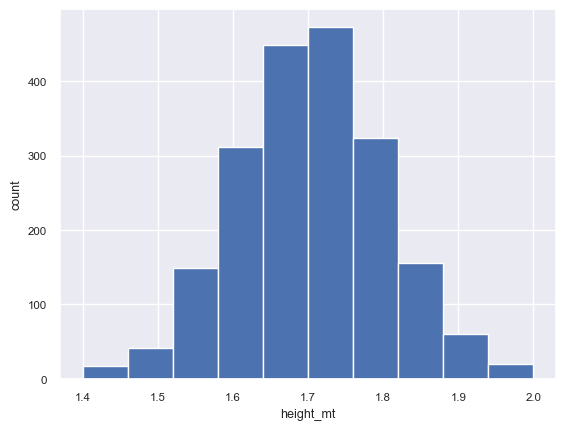

In [39]:
fig, ax = plt.subplots()
hist(ax, df_bmi.select('height_mt'))
ax.set_xlabel('height_mt')
ax.set_ylabel('count')
plt.show()

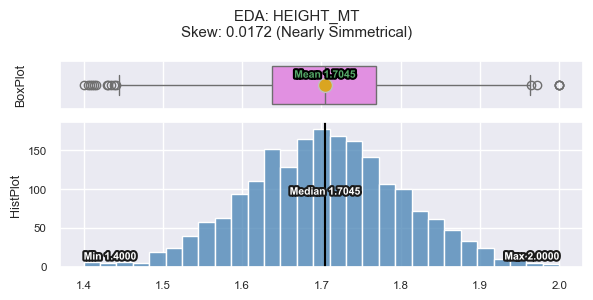

In [40]:
histogram_boxplot(df_bmi.select('height_mt').toPandas().height_mt)

In [41]:
df_bmi = df_bmi.drop(*['height_bin'])

# Getting the range
min_max = df_bmi.select('height_mt').agg(F.min('height_mt'), F.max('height_mt')).collect()[0]
print('Range:', min_max)

# Applying buckets
bucketizer = Bucketizer(splits=[min_max[0], 1.6, 1.8, min_max[1]],
                        inputCol="height_mt", outputCol="height_bin")
df_bmi = bucketizer.transform(df_bmi)

# Assign categos to bins
df_bmi = df_bmi.withColumn("height_cat", F.when(df_bmi["height_bin"] == 0, "short")
                                          .when(df_bmi["height_bin"] == 1, "average")
                                          .when(df_bmi["height_bin"] == 2, "tall")
)

# Inspecting results
df_bmi.groupBy("height_bin").count().sort('count').show()
df_bmi.groupBy("height_cat").count().sort('count').show()
df_bmi.limit(5)

Range: Row(min(height_mt)=1.4, max(height_mt)=2.0)
+----------+-----+
|height_bin|count|
+----------+-----+
|       0.0|  286|
|       2.0|  331|
|       1.0| 1383|
+----------+-----+

+----------+-----+
|height_cat|count|
+----------+-----+
|     short|  286|
|      tall|  331|
|   average| 1383|
+----------+-----+



height_mt,mass_kg,height_bin,height_cat
1.7496714153011232,54.45891245893144,1.0,average
1.6861735698828815,63.856884442309884,1.0,average
1.7647688538100692,52.576750887652835,1.0,average
1.8523029856408024,60.80132254426298,2.0,tall
1.6765846625276664,40.0,1.0,average


### Mass & Height to BMI

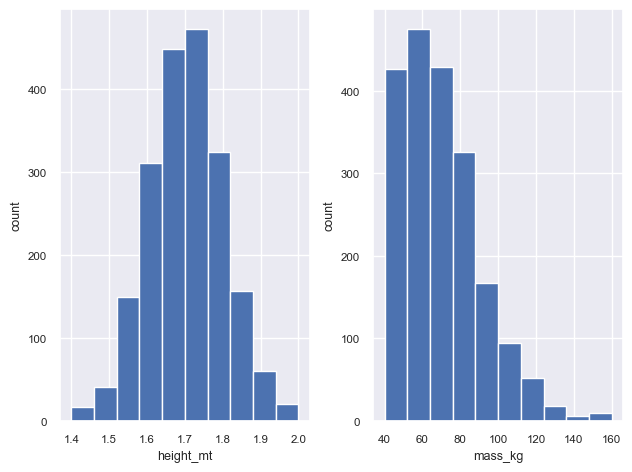

In [42]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
hist(ax1, df_bmi.select('height_mt'))
ax1.set_xlabel('height_mt')
ax1.set_ylabel('count')
hist(ax2, df_bmi.select('mass_kg'))
ax2.set_xlabel('mass_kg')
ax2.set_ylabel('count')
plt.tight_layout()
plt.show()

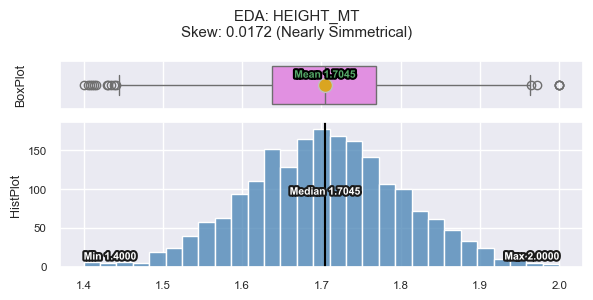

In [43]:
histogram_boxplot(df_bmi.select('height_mt').toPandas().height_mt)

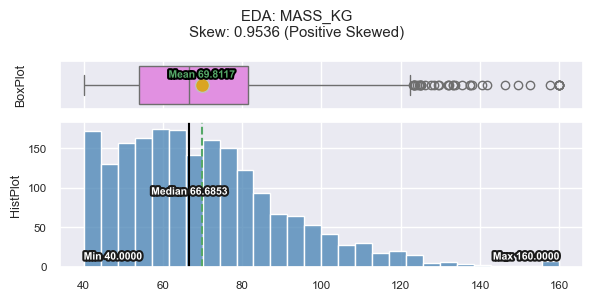

In [44]:
histogram_boxplot(df_bmi.select('mass_kg').toPandas().mass_kg)

In [45]:
df_bmi = df_bmi.withColumn("bmi", df_bmi.mass_kg/F.pow(df_bmi.height_mt, 2))
df_bmi.limit(10)

height_mt,mass_kg,height_bin,height_cat,bmi
1.7496714153011232,54.45891245893144,1.0,average,17.789181689290125
1.6861735698828815,63.856884442309884,1.0,average,22.45965963118948
1.7647688538100692,52.576750887652835,1.0,average,16.881774062083664
1.8523029856408024,60.80132254426298,2.0,tall,17.721030482142833
1.6765846625276664,40.0,1.0,average,14.230134781160787
1.676586304305082,71.09294548112771,1.0,average,25.291505371763094
1.857921281550739,66.71045202096944,2.0,tall,19.325879380038685
1.776743472915291,52.189086945201055,1.0,average,16.53218442890817
1.6530525614065048,81.26973634141737,1.0,average,29.740997129407827
1.7542560043585964,88.34689389144363,1.0,average,28.70815892597601


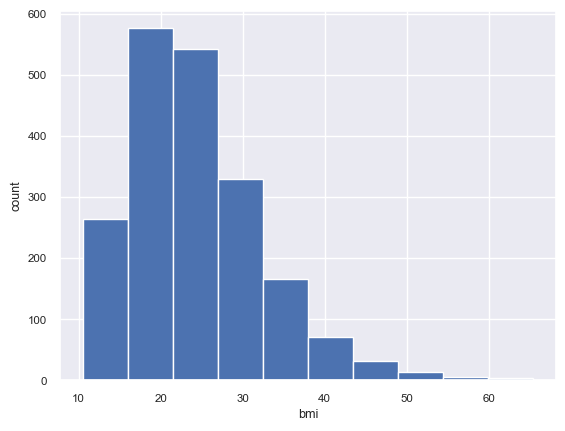

In [46]:
fig, ax = plt.subplots()
hist(ax, df_bmi.select('bmi'))
ax.set_xlabel('bmi')
ax.set_ylabel('count')
plt.show()

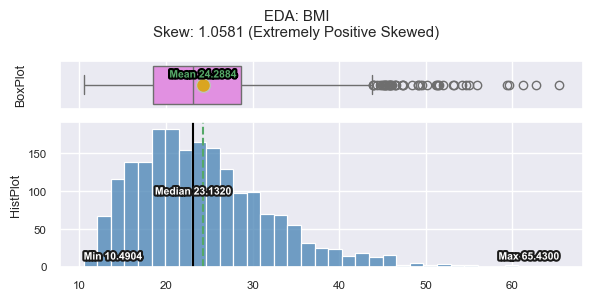

In [47]:
histogram_boxplot(df_bmi.select('bmi').toPandas().bmi)

# Flights Dataset

In [48]:
df_flights = flights_data.select('*')
df_flights.groupby('org').count().sort(F.col("count").desc()).show()
df_flights.limit(2)

+---+-----+
|org|count|
+---+-----+
|ORD|17928|
|SFO| 9129|
|JFK| 7516|
|LGA| 4539|
|SMF| 2955|
|SJC| 2952|
|TUS| 1033|
|OGG|  970|
+---+-----+



mon,dom,dow,carrier,flight,org,mile,depart,duration,delay,km
0,22,2,UA,1107,ORD,316,16.33,82,30,509.0
2,20,4,UA,226,SFO,337,6.17,82,-8,542.0


## Ex. 1 - Encoding flight origin

The `org` column in the flights data is a categorical variable giving the airport from which a flight departs.
- ORD — O'Hare International Airport (Chicago)
- SFO — San Francisco International Airport
- JFK — John F Kennedy International Airport (New York)
- LGA — La Guardia Airport (New York)
- SMF — Sacramento
- SJC — San Jose
- OGG — Kahului (Hawaii)

**Instructions:**

1. Import the one-hot encoder class.
2. Create a one-hot encoder instance, naming the input column `org_idx` and the output column `org_vec`.
3. Apply the one-hot encoder to the flights data.
4. Generate a summary of the mapping from categorical values to binary encoded dummy variables. Include only unique values and order by org_idx.

In [49]:
df_flights = df_flights.drop(*['org_idx', 'org_vec'])

# Indexing the org. column
indexer_flights = StringIndexer(inputCol='org', outputCol='org_idx').fit(df_flights)
df_flights = indexer_flights.transform(df_flights)

# Vectorize the index values
onehot_flights = OneHotEncoder(inputCols=['org_idx'], outputCols=['org_vec']).fit(df_flights)
print(f"How many category levels? {onehot_flights.categorySizes}")
df_flights = onehot_flights.transform(df_flights)

# Inspect results
df_flights.select('org', 'org_idx', 'org_vec').distinct().orderBy('org_idx').show()
df_flights.limit(2)

# Getting the encoded categories
colIdx = df_flights.select('org', "org_idx").distinct().rdd.collectAsMap()
colIdx =  sorted((value, key) for (key, value) in colIdx.items())
newCols_org = list(map(lambda x: x[1], colIdx))
newCols_org

How many category levels? [8]
+---+-------+-------------+
|org|org_idx|      org_vec|
+---+-------+-------------+
|ORD|    0.0|(7,[0],[1.0])|
|SFO|    1.0|(7,[1],[1.0])|
|JFK|    2.0|(7,[2],[1.0])|
|LGA|    3.0|(7,[3],[1.0])|
|SMF|    4.0|(7,[4],[1.0])|
|SJC|    5.0|(7,[5],[1.0])|
|TUS|    6.0|(7,[6],[1.0])|
|OGG|    7.0|    (7,[],[])|
+---+-------+-------------+



['ORD', 'SFO', 'JFK', 'LGA', 'SMF', 'SJC', 'TUS', 'OGG']

### Encoding carrier

In [50]:
df_flights = df_flights.drop(*['carrier_idx', 'carrier_vec'])

# Indexing the carrier column
indexer_flights = StringIndexer(inputCol='carrier', outputCol='carrier_idx').fit(df_flights)
df_flights = indexer_flights.transform(df_flights)

# Vectorize the index values
onehot_flights = OneHotEncoder(inputCols=['carrier_idx'], outputCols=['carrier_vec']).fit(df_flights)
print(f"How many category levels? {onehot_flights.categorySizes}")
df_flights = onehot_flights.transform(df_flights)

# Inspect results
df_flights.select('carrier', 'carrier_idx', 'carrier_vec').distinct().orderBy('carrier_idx').show()
df_flights.limit(2)

# Getting the encoded categories
colIdx = df_flights.select('carrier', "carrier_idx").distinct().rdd.collectAsMap()
colIdx =  sorted((value, key) for (key, value) in colIdx.items())
newCols_carrier = list(map(lambda x: x[1], colIdx))
newCols_carrier

How many category levels? [9]
+-------+-----------+-------------+
|carrier|carrier_idx|  carrier_vec|
+-------+-----------+-------------+
|     UA|        0.0|(8,[0],[1.0])|
|     AA|        1.0|(8,[1],[1.0])|
|     OO|        2.0|(8,[2],[1.0])|
|     WN|        3.0|(8,[3],[1.0])|
|     B6|        4.0|(8,[4],[1.0])|
|     OH|        5.0|(8,[5],[1.0])|
|     US|        6.0|(8,[6],[1.0])|
|     HA|        7.0|(8,[7],[1.0])|
|     AQ|        8.0|    (8,[],[])|
+-------+-----------+-------------+



['UA', 'AA', 'OO', 'WN', 'B6', 'OH', 'US', 'HA', 'AQ']

## Ex. 2 - Flight duration model: Just distance

In this exercise you'll build a regression model to predict flight duration (the duration column).

For the moment you'll keep the model simple, including only the distance of the flight (the `km` column) as a predictor.

**Instructions:**

1. Create a linear regression object. Specify the name of the label column. Fit it to the training data.
2. Make predictions on the testing data.
3. Create a regression evaluator object and use it to evaluate RMSE on the testing data.

In [51]:
df_flights = df_flights.drop(*['features'])

# Preparing feature column
feature_cols_flights = ['km']
assembler_flights = VectorAssembler(inputCols=feature_cols_flights, outputCol='features')
df_flights = assembler_flights.transform(df_flights)
df_flights.select(feature_cols_flights + ['features', 'duration']).show(5, truncate=False)

+------+--------+--------+
|km    |features|duration|
+------+--------+--------+
|509.0 |[509.0] |82      |
|542.0 |[542.0] |82      |
|1989.0|[1989.0]|195     |
|885.0 |[885.0] |102     |
|1180.0|[1180.0]|135     |
+------+--------+--------+
only showing top 5 rows



In [52]:
# Split into train and test
df_flights_train, df_flights_test = df_flights.randomSplit([0.8, 0.2], seed=SEED)
print(f"Training set: {df_flights_train.count()}, Testing set: {df_flights_test.count()}")

# Building the regression model
model_lr_flights = LinearRegression(labelCol='duration').fit(df_flights_train)

# Predict on flights_test (testing data).
predictions_flights = model_lr_flights.transform(df_flights_test)
predictions_flights.select('duration', 'prediction').show(5)

Training set: 37601, Testing set: 9421
+--------+------------------+
|duration|        prediction|
+--------+------------------+
|     560| 561.0619125749561|
|     310| 346.9912658584909|
|     165|133.37496080467133|
|     120|133.37496080467133|
|     240|213.26336981983607|
+--------+------------------+
only showing top 5 rows



In [53]:
# Evaluate the model
eval_flights = RegressionEvaluator(labelCol='duration')

print(f'''
RMSE: {eval_flights.evaluate(predictions_flights)}
 MAE: {eval_flights.evaluate(predictions_flights, {eval_flights.metricName: "mae"})}
  R²: {eval_flights.evaluate(predictions_flights, {eval_flights.metricName: "r2"})}
 MSE: {eval_flights.evaluate(predictions_flights, {eval_flights.metricName: "mse"})}
''')


RMSE: 16.922105560725083
 MAE: 12.991268564551982
  R²: 0.9626927672076624
 MSE: 286.3576566083227



## Ex. 3 - Interpreting the coefficients

The linear regression model for flight duration as a function of distance takes the form
$$ duration = \alpha + \beta \times distance$$

where:
- $ \alpha $ — intercept (component of duration which does not depend on distance) and
- $ \beta $ — coefficient (rate at which duration increases as a function of distance; also called the slope).

By looking at the coefficients of your model you will be able to infer:
- how much of the average flight duration is actually spent on the ground and
- what the average speed is during a flight.

**Instructions:**

1. What's the intercept?
2. What are the coefficients? This is a vector.
3. Extract the element from the vector which corresponds to the slope for distance.
4. Find the average speed in km per hour.

Considering $ x = \frac{min}{km}$, and with the knowledge $ min 🠢 min * \frac{hr}{60min} 🠢 hr $

$$ x 🠢 \frac{1}{x} 🠢 \frac{1}{x \times \frac{1}{60}} 🠢 \frac{60}{x} 🠢 \frac{60}{\frac{min}{km}} $$


In [54]:
# Intercept (average minutes on ground)
inter = model_lr_flights.intercept
print('Intercept:', inter)

# Coefficients
coefs = model_lr_flights.coefficients
print('Coefficients: ', coefs)

# Average minutes per km - slope for distance.
minutes_per_km = model_lr_flights.coefficients[0]
print('Average minutes per km:', minutes_per_km)

# Average speed in km per hour
avg_speed = 60 / minutes_per_km
print('Average speed in km per hour:', avg_speed)

Intercept: 44.02110048439229
Coefficients:  [0.07572361044091444]
Average minutes per km: 0.07572361044091444
Average speed in km per hour: 792.3552462783949


## Ex. 4 - Flight duration model: Adding origin airport

Some airports are busier than others. Some airports are bigger than others too. Flights departing from large or busy airports are likely to spend more time taxiing or waiting for their takeoff slot. So it stands to reason that the duration of a flight might depend not only on the distance being covered but also the airport from which the flight departs.

You are going to make the regression model a little more sophisticated by including the departure airport as a predictor.

**Instructions**

1. Fit a linear regression model to the training data.
2. Make predictions for the testing data.
3. Calculate the RMSE for predictions on the testing data.

In [55]:
df_flights = df_flights.drop(*['features'])

# Preparing feature column
feature_cols_flights = ['km', 'org_vec']
assembler_flights = VectorAssembler(inputCols=feature_cols_flights, outputCol='features')
df_flights = assembler_flights.transform(df_flights)
df_flights.select(feature_cols_flights + ['features', 'duration']).show(5, truncate=False)

+------+-------------+----------------------+--------+
|km    |org_vec      |features              |duration|
+------+-------------+----------------------+--------+
|509.0 |(7,[0],[1.0])|(8,[0,1],[509.0,1.0]) |82      |
|542.0 |(7,[1],[1.0])|(8,[0,2],[542.0,1.0]) |82      |
|1989.0|(7,[0],[1.0])|(8,[0,1],[1989.0,1.0])|195     |
|885.0 |(7,[1],[1.0])|(8,[0,2],[885.0,1.0]) |102     |
|1180.0|(7,[0],[1.0])|(8,[0,1],[1180.0,1.0])|135     |
+------+-------------+----------------------+--------+
only showing top 5 rows



In [56]:
# Split into train and test
df_flights_train, df_flights_test = df_flights.randomSplit([0.8, 0.2], seed=SEED)
print(f"Training set: {df_flights_train.count()}, Testing set: {df_flights_test.count()}")

# Building the regression model
model_lr_flights = LinearRegression(labelCol='duration').fit(df_flights_train)

# Predict on flights_test (testing data).
predictions_flights = model_lr_flights.transform(df_flights_test)
predictions_flights.select('features', 'duration', 'prediction').show(5)

Training set: 37601, Testing set: 9421
+--------------------+--------+------------------+
|            features|duration|        prediction|
+--------------------+--------+------------------+
|(8,[0,1],[6828.0,...|     560| 551.8166177505183|
|    (8,[0],[4001.0])|     310| 312.8638012590577|
|(8,[0,4],[1180.0,...|     165| 150.2985317892182|
|(8,[0,1],[1180.0,...|     120|132.06409992722158|
|(8,[0,4],[2235.0,...|     240|228.70485372682055|
+--------------------+--------+------------------+
only showing top 5 rows



In [57]:
# Evaluate the model
eval_flights = RegressionEvaluator(labelCol='duration')

print(f'''
RMSE: {eval_flights.evaluate(predictions_flights)}
 MAE: {eval_flights.evaluate(predictions_flights, {eval_flights.metricName: "mae"})}
  R²: {eval_flights.evaluate(predictions_flights, {eval_flights.metricName: "r2"})}
 MSE: {eval_flights.evaluate(predictions_flights, {eval_flights.metricName: "mse"})}
''')


RMSE: 11.01723475816237
 MAE: 8.52889968694435
  R²: 0.9841864475072917
 MSE: 121.37946171646108



## Ex. 5 - Interpreting coefficients

Remember that origin airport, org, has eight possible values (ORD, SFO, JFK, LGA, SMF, SJC, TUS and OGG) which have been one-hot encoded to seven dummy variables in org_dummy.

The values for km and org_dummy have been assembled into features, which has eight columns with sparse representation. Column indices in features are as follows:
- 0 — km
- 1 — ORD
- 2 — SFO
- 3 — JFK
- 4 — LGA
- 5 — SMF
- 6 — SJC and
- 7 — TUS.

Note that OGG does not appear in this list because it is the reference level for the origin airport category.
The coefficients attribute is a list, where the first element indicates how flight duration changes with flight distance.

**Instructions:**

1. Find the average speed in km per hour. This will be different to the value that you got earlier because your model is now more sophisticated.
2. What's the average time on the ground at OGG?
3. What's the average time on the ground at JFK?
4. What's the average time on the ground at LGA?

In [58]:
print(f'''
Intercept: {model_lr_flights.intercept}
Coefficients:
{model_lr_flights.coefficients}

Feature cols: {feature_cols_flights}
Encoded categos (org_vec): {newCols_org[:-1]}
''')

# Summarizing
coefficient_len = len(model_lr_flights.coefficients)
pd.DataFrame({
    'Slope': ['Intercept'] + ['Coefficients']*coefficient_len,
    'Feature': [''] + feature_cols_flights[:-1] + newCols_org[:-1],
    'value': [model_lr_flights.intercept] + list(model_lr_flights.coefficients)
}, index=[0]+list(range(coefficient_len)))


Intercept: 15.514328204700384
Coefficients:
[0.07431878856644772,28.853601214112874,20.804901599913162,52.63560265547633,47.08803307610952,15.957548580589807,18.57777101930432,18.400432009994926]

Feature cols: ['km', 'org_vec']
Encoded categos (org_vec): ['ORD', 'SFO', 'JFK', 'LGA', 'SMF', 'SJC', 'TUS']



,Slope,Feature,value
0,Intercept,,15.514328
0,Coefficients,km,0.074319
1,Coefficients,ORD,28.853601
2,Coefficients,SFO,20.804902
3,Coefficients,JFK,52.635603
4,Coefficients,LGA,47.088033
5,Coefficients,SMF,15.957549
6,Coefficients,SJC,18.577771
7,Coefficients,TUS,18.400432


In [59]:
# Average speed in km per hour
avg_speed_hour = 60 / (model_lr_flights.coefficients[0])  # coeff for km
print('Average speed in km per hour:', avg_speed_hour)

# Average minutes on ground at OGG
inter = model_lr_flights.intercept
print('Average minutes on ground at OGG:', inter)

# Average minutes on ground at JFK
avg_ground_jfk = model_lr_flights.intercept + model_lr_flights.coefficients[3]   # coeff for JFK=3
print('Average minutes on ground at JFK:', avg_ground_jfk)

# Average minutes on ground at LGA
avg_ground_lga = model_lr_flights.intercept + model_lr_flights.coefficients[4]   # coeff for LGA=4
print('Average minutes on ground at LGA:', avg_ground_lga)

Average speed in km per hour: 807.3328583169056
Average minutes on ground at OGG: 15.514328204700384
Average minutes on ground at JFK: 68.14993086017671
Average minutes on ground at LGA: 62.6023612808099


## Ex. 6 - Bucketing departure time

Time of day data are a challenge with regression models. They are also a great candidate for bucketing.

We need to convert the flight departure times from numeric values between 0 (corresponding to 00:00) and 24 (corresponding to 24:00) to binned values. We'll then take those binned values and one-hot encode them.

**Instructions:**

1. Create a bucketizer object with bin boundaries at `0, 3, 6, …, 24` which correspond to times `0:00, 03:00, 06:00, …, 24:00`. Specify input column as `depart` and output column as `depart_bin``.
2. Bucket the departure times in the flights data. Show the first five values for depart and `depart_bin`.
3. Create a one-hot encoder object. Specify output column as `depart_vec`.
4. Train the encoder on the data and then use it to convert the bucketed departure times to vec variables. Show the first five values for `depart`, `depart_bin` and `depart_vec`.

In [60]:
df_flights = df_flights.drop('depart_bin', 'depart_vec')

# Setting the bins for the buckets
bins = list(range(0, 25, 3))
newCols_depart = [f'{bins[i]} - {bins[i+1]}' for i in range(len(bins)-1)]

# Create buckets at 3 hour intervals through the day
buckets = Bucketizer(splits=bins, inputCol='depart', outputCol='depart_bin')
df_flights = buckets.transform(df_flights)
df_flights = df_flights.withColumn('depart_cat', F.when(df_flights["depart_bin"] == 0, newCols_depart[0])
                                                  .when(df_flights["depart_bin"] == 1, newCols_depart[1])
                                                  .when(df_flights["depart_bin"] == 2, newCols_depart[2])
                                                  .when(df_flights["depart_bin"] == 3, newCols_depart[3])
                                                  .when(df_flights["depart_bin"] == 4, newCols_depart[4])
                                                  .when(df_flights["depart_bin"] == 5, newCols_depart[5])
                                                  .when(df_flights["depart_bin"] == 6, newCols_depart[6])
                                                  .otherwise(newCols_depart[7]))

# Create a one-hot encoder
onehot = OneHotEncoder(inputCols=['depart_bin'], outputCols=['depart_vec'])
df_flights = onehot.fit(df_flights).transform(df_flights)

# Reviewing the encoded values from the catego column
print(f'''
Category level: {len(newCols_depart)}
Encoded without the last catego: {newCols_depart}
Dropped catego: {newCols_depart[-1]}
''')

# Review result
df_flights.select('depart_bin', 'depart_vec', 'depart_cat').distinct().sort('depart_bin').show()


Category level: 8
Encoded without the last catego: ['0 - 3', '3 - 6', '6 - 9', '9 - 12', '12 - 15', '15 - 18', '18 - 21', '21 - 24']
Dropped catego: 21 - 24

+----------+-------------+----------+
|depart_bin|   depart_vec|depart_cat|
+----------+-------------+----------+
|       0.0|(7,[0],[1.0])|     0 - 3|
|       1.0|(7,[1],[1.0])|     3 - 6|
|       2.0|(7,[2],[1.0])|     6 - 9|
|       3.0|(7,[3],[1.0])|    9 - 12|
|       4.0|(7,[4],[1.0])|   12 - 15|
|       5.0|(7,[5],[1.0])|   15 - 18|
|       6.0|(7,[6],[1.0])|   18 - 21|
|       7.0|    (7,[],[])|   21 - 24|
+----------+-------------+----------+



## Ex. 7 - Flight duration model: Adding departure time

In the previous exercise the departure time was bucketed and converted to vec variables. Now you're going to include those vec variables in a regression model for flight duration.

The `km`, `org_vec` and `depart_vec` columns have been assembled into features, where `km` is index `0`, `org_vec` runs from index `1` to `7` and `depart_vec` from index `8` to `14`.

The data have been split into training and testing sets and a linear regression model, regression, has been built on the training data. Predictions have been made on the testing data.

**Instructions:**

1. Find the RMSE for predictions on the testing data.
2. Find the average time spent on the ground for flights departing from OGG between 21:00 and 24:00.
3. Find the average time spent on the ground for flights departing from OGG between 03:00 and 06:00.
4. Find the average time spent on the ground for flights departing from JFK between 03:00 and 06:00.

In [61]:
df_flights = df_flights.drop(*['features'])

# Preparing feature column
feature_cols_flights = ['km', 'org_vec', 'depart_vec']
assembler_flights = VectorAssembler(inputCols=feature_cols_flights, outputCol='features')
df_flights = assembler_flights.transform(df_flights)
df_flights.select(feature_cols_flights + ['features', 'duration']).show(5, truncate=False)

+------+-------------+-------------+------------------------------+--------+
|km    |org_vec      |depart_vec   |features                      |duration|
+------+-------------+-------------+------------------------------+--------+
|509.0 |(7,[0],[1.0])|(7,[5],[1.0])|(15,[0,1,13],[509.0,1.0,1.0]) |82      |
|542.0 |(7,[1],[1.0])|(7,[2],[1.0])|(15,[0,2,10],[542.0,1.0,1.0]) |82      |
|1989.0|(7,[0],[1.0])|(7,[3],[1.0])|(15,[0,1,11],[1989.0,1.0,1.0])|195     |
|885.0 |(7,[1],[1.0])|(7,[2],[1.0])|(15,[0,2,10],[885.0,1.0,1.0]) |102     |
|1180.0|(7,[0],[1.0])|(7,[3],[1.0])|(15,[0,1,11],[1180.0,1.0,1.0])|135     |
+------+-------------+-------------+------------------------------+--------+
only showing top 5 rows



## Ex. 8 - Flight duration model: More features!

Let's add more features to our model. This will not necessarily result in a better model. Adding some features might improve the model. Adding other features might make it worse.

More features will always make the model more complicated and difficult to interpret.

These are the features you'll include in the next model:
- `km`
- `org` (origin airport, one-hot encoded, 8 levels)
- `depart` (departure time, binned in 3 hour intervals, one-hot encoded, 8 levels)
- `dow` (departure day of week, one-hot encoded, 7 levels) and
- `mon` (departure month, one-hot encoded, 12 levels).

These have been assembled into the features column, which is a sparse representation of 32 columns (remember one-hot encoding produces a number of columns which is one fewer than the number of levels).

**Instructions:**

1. Fit a linear regression model to the training data.
2. Generate predictions for the testing data.
3. Calculate the RMSE on the testing data.
4. Look at the model coefficients. Are any of them zero?

In [62]:
# Reviewing the data
df_flights.limit(2)

mon,dom,dow,carrier,flight,org,mile,depart,duration,delay,km,org_idx,org_vec,carrier_idx,carrier_vec,depart_bin,depart_cat,depart_vec,features
0,22,2,UA,1107,ORD,316,16.33,82,30,509.0,0.0,"(7,[0],[1.0])",0.0,"(8,[0],[1.0])",5.0,15 - 18,"(7,[5],[1.0])","(15,[0,1,13],[509..."
2,20,4,UA,226,SFO,337,6.17,82,-8,542.0,1.0,"(7,[1],[1.0])",0.0,"(8,[0],[1.0])",2.0,6 - 9,"(7,[2],[1.0])","(15,[0,2,10],[542..."


### Encoding

In [63]:
df_flights = df_flights.drop(*['dow_vec'])

# Encoding dow
onehot_flights = OneHotEncoder(inputCols=['dow'], outputCols=['dow_vec']).fit(df_flights)
df_flights = onehot_flights.transform(df_flights)

# Getting the encoded values from the catego column
colIdx = df_flights.select('dow').distinct().sort('dow').rdd.collect()
newCols_dow = list(map(lambda x: f'dow_{x[0]}', colIdx))
print(f'''
Category level: {len(newCols_dow)}
Encoded without the last catego: {newCols_dow[:-1]}
Dropped catego: {newCols_dow[-1]}
''')

# Inspect results
df_flights.select('dow', 'dow_vec').distinct().sort('dow').show()


Category level: 7
Encoded without the last catego: ['dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5']
Dropped catego: dow_6

+---+-------------+
|dow|      dow_vec|
+---+-------------+
|  0|(6,[0],[1.0])|
|  1|(6,[1],[1.0])|
|  2|(6,[2],[1.0])|
|  3|(6,[3],[1.0])|
|  4|(6,[4],[1.0])|
|  5|(6,[5],[1.0])|
|  6|    (6,[],[])|
+---+-------------+



In [64]:
df_flights = df_flights.drop(*['mon_vec'])

# Encoding mon
onehot_flights = OneHotEncoder(inputCols=['mon'], outputCols=['mon_vec']).fit(df_flights)
df_flights = onehot_flights.transform(df_flights)

# Getting the encoded values from the catego column
colIdx = df_flights.select('mon').distinct().sort('mon').rdd.collect()
newCols_mon = list(map(lambda x: f'mon_{x[0]}', colIdx))
print(f'''
Category level: {len(newCols_mon)}
Encoded without the last catego: {newCols_mon[:-1]}
Dropped catego: {newCols_mon[-1]}
''')

# Inspect results
df_flights.select('mon', 'mon_vec').distinct().sort('mon').show()


Category level: 12
Encoded without the last catego: ['mon_0', 'mon_1', 'mon_2', 'mon_3', 'mon_4', 'mon_5', 'mon_6', 'mon_7', 'mon_8', 'mon_9', 'mon_10']
Dropped catego: mon_11

+---+---------------+
|mon|        mon_vec|
+---+---------------+
|  0| (11,[0],[1.0])|
|  1| (11,[1],[1.0])|
|  2| (11,[2],[1.0])|
|  3| (11,[3],[1.0])|
|  4| (11,[4],[1.0])|
|  5| (11,[5],[1.0])|
|  6| (11,[6],[1.0])|
|  7| (11,[7],[1.0])|
|  8| (11,[8],[1.0])|
|  9| (11,[9],[1.0])|
| 10|(11,[10],[1.0])|
| 11|     (11,[],[])|
+---+---------------+



### Assemble new features vector

In [65]:
df_flights = df_flights.drop(*['features'])

# Preparing feature column
feature_cols_flights = ['km', 'org_vec', 'depart_vec', 'dow_vec', 'mon_vec']
assembler_flights = VectorAssembler(inputCols=feature_cols_flights, outputCol='features')
df_flights = assembler_flights.transform(df_flights)
df_flights.select(feature_cols_flights + ['features', 'duration']).show(5, truncate=40)

+------+-------------+-------------+-------------+--------------+----------------------------------------+--------+
|    km|      org_vec|   depart_vec|      dow_vec|       mon_vec|                                features|duration|
+------+-------------+-------------+-------------+--------------+----------------------------------------+--------+
| 509.0|(7,[0],[1.0])|(7,[5],[1.0])|(6,[2],[1.0])|(11,[0],[1.0])|(32,[0,1,13,17,21],[509.0,1.0,1.0,1.0...|      82|
| 542.0|(7,[1],[1.0])|(7,[2],[1.0])|(6,[4],[1.0])|(11,[2],[1.0])|(32,[0,2,10,19,23],[542.0,1.0,1.0,1.0...|      82|
|1989.0|(7,[0],[1.0])|(7,[3],[1.0])|(6,[1],[1.0])|(11,[9],[1.0])|(32,[0,1,11,16,30],[1989.0,1.0,1.0,1....|     195|
| 885.0|(7,[1],[1.0])|(7,[2],[1.0])|(6,[1],[1.0])|(11,[5],[1.0])|(32,[0,2,10,16,26],[885.0,1.0,1.0,1.0...|     102|
|1180.0|(7,[0],[1.0])|(7,[3],[1.0])|    (6,[],[])|(11,[7],[1.0])|   (32,[0,1,11,28],[1180.0,1.0,1.0,1.0])|     135|
+------+-------------+-------------+-------------+--------------+-------

### Split into train and test

In [66]:
# Split into train and test
df_flights_train, df_flights_test = df_flights.randomSplit([0.8, 0.2], seed=SEED)
print(f"Training set: {df_flights_train.count()}, Testing set: {df_flights_test.count()}")

Training set: 37601, Testing set: 9421


### Build a new LinearRegression model

In [67]:
# Fit linear regression model to training data
model_lr_flights = LinearRegression(labelCol='duration').fit(df_flights_train)

# Make predictions on testing data
predictions_flights = model_lr_flights.transform(df_flights_test)

# Evaluate the model
eval_flights = RegressionEvaluator(labelCol='duration')

# R² will be negative when the line or curve does an awful job of fitting the data.
print(f'''
RMSE: {eval_flights.evaluate(predictions_flights)}
 MAE: {eval_flights.evaluate(predictions_flights, {eval_flights.metricName: "mae"})}
  R²: {eval_flights.evaluate(predictions_flights, {eval_flights.metricName: "r2"})}
 MSE: {eval_flights.evaluate(predictions_flights, {eval_flights.metricName: "mse"})}
''')


RMSE: 10.642834459372345
 MAE: 8.288160687111343
  R²: 0.9852429736899886
 MSE: 113.26992532960344



### Inspect Intercept and coefficients

In [68]:
# Reviewing intercept and coefficients
print(f'''
Intercept: {model_lr_flights.intercept}
Coefficients:
{model_lr_flights.coefficients}

Feature cols: {feature_cols_flights}
Encoded categos (org_vec): {newCols_org[:-1]}
Encoded categos (depart_vec): {newCols_depart[:-1]}
Encoded categos (dow_vec): {newCols_dow[:-1]}
Encoded categos (mon_vec): {newCols_mon[:-1]}
''')

# Saving for later review
coefficient_len = len(model_lr_flights.coefficients)
feature_flights_importance = pd.DataFrame({
    'Slope': ['Intercept'] + ['Coefficients']*coefficient_len,
    'Feature': [''] + feature_cols_flights[:-4] + newCols_org[:-1] + newCols_depart[:-1] + \
               newCols_dow[:-1] + newCols_mon[:-1],
    'LR': [model_lr_flights.intercept] + list(model_lr_flights.coefficients)
})
feature_flights_importance


Intercept: 12.894562673786163
Coefficients:
[0.07442209559515502,27.659450151115774,20.459189306237185,51.85957014048379,46.186644617016924,15.340633664518782,17.845461098188395,17.90535863122572,-15.273418440592232,0.7300571207888024,4.131977434639745,7.126546170088425,4.6641625375768125,8.839698583866427,8.806754088197247,0.46746560369110274,0.16539185557587202,-0.2501296998131571,0.19119328659810755,0.1721166698980672,0.05606261143314854,-2.146131233580401,-2.39022447418759,-2.157273002188367,-3.787912634052204,-4.228120102690946,-4.440407861585883,-4.621437276855744,-4.463261506930198,-4.02677009910407,-2.8316270307373923,-0.8592174134481407]

Feature cols: ['km', 'org_vec', 'depart_vec', 'dow_vec', 'mon_vec']
Encoded categos (org_vec): ['ORD', 'SFO', 'JFK', 'LGA', 'SMF', 'SJC', 'TUS']
Encoded categos (depart_vec): ['0 - 3', '3 - 6', '6 - 9', '9 - 12', '12 - 15', '15 - 18', '18 - 21']
Encoded categos (dow_vec): ['dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5']
Encoded categos

,Slope,Feature,LR
0,Intercept,,12.894563
1,Coefficients,km,0.074422
2,Coefficients,ORD,27.659450
3,Coefficients,SFO,20.459189
4,Coefficients,JFK,51.859570
5,Coefficients,LGA,46.186645
6,Coefficients,SMF,15.340634
7,Coefficients,SJC,17.845461
8,Coefficients,TUS,17.905359
9,Coefficients,0 - 3,-15.273418


## Ex. 9 - Flight duration model: Regularization!

In the previous exercise you added more predictors to the flight duration model. The model performed well on testing data, but with so many coefficients it was difficult to interpret.

In this exercise you'll use Lasso regression (regularized with a L1 penalty) to create a more parsimonious model. Many of the coefficients in the resulting model will be set to zero. This means that only a subset of the predictors actually contribute to the model. Despite the simpler model, it still produces a good RMSE on the testing data.

You'll use a specific value for the regularization strength. Later you'll learn how to find the best value using cross validation.

There are two parameters for this model, λ (regParam) and α (elasticNetParam), where α determines the type of regularization and λ gives the strength of regularization.

**Instructions:**

1. Fit a linear regression model to the training data. Set the regularization strength to 1.
2. Calculate the RMSE on the testing data.
3. Look at the model coefficients.
4. How many of the coefficients are equal to zero?

### Build a Lasso regression ($ \alpha = 1 $ | $ \lambda = 1 $)

In [69]:
# Building the lasso model
lasso_flights = LinearRegression(labelCol='duration',
                                    elasticNetParam=1, regParam=1).fit(df_flights_train)

# Evaluate the model
predictions_flights = lasso_flights.transform(df_flights_test)
eval_flights = RegressionEvaluator(labelCol='duration')
print(f'''
RMSE: {eval_flights.evaluate(predictions_flights)}
 MAE: {eval_flights.evaluate(predictions_flights, {eval_flights.metricName: "mae"})}
  R²: {eval_flights.evaluate(predictions_flights, {eval_flights.metricName: "r2"})}
 MSE: {eval_flights.evaluate(predictions_flights, {eval_flights.metricName: "mse"})}
''')


RMSE: 11.549663590335594
 MAE: 8.902305404675984
  R²: 0.9826210750958084
 MSE: 133.39472904992368



### Inspect Intercept and coefficients

In [70]:
# Reviewing intercept and coefficients
feature_flights_importance['Lasso'] = [lasso_flights.intercept] + list(lasso_flights.coefficients)
feature_flights_importance

,Slope,Feature,LR,Lasso
0,Intercept,,12.894563,38.013352
1,Coefficients,km,0.074422,0.073541
2,Coefficients,ORD,27.659450,5.697832
3,Coefficients,SFO,20.459189,0.000000
4,Coefficients,JFK,51.859570,28.901940
5,Coefficients,LGA,46.186645,22.063034
6,Coefficients,SMF,15.340634,-2.289374
7,Coefficients,SJC,17.845461,0.000000
8,Coefficients,TUS,17.905359,0.000000
9,Coefficients,0 - 3,-15.273418,0.000000


### Selecting the most important features

In [71]:
# Number of zero coefficients
zero_coeff = sum([beta==0 for beta in lasso_flights.coefficients])
print("Number of coefficients equal to 0:", zero_coeff)

# Most important features
print('Most important features:')
feature_flights_importance[feature_flights_importance.Lasso.round(3)!= 0]

Number of coefficients equal to 0: 25
Most important features:


,Slope,Feature,LR,Lasso
0,Intercept,,12.894563,38.013352
1,Coefficients,km,0.074422,0.073541
2,Coefficients,ORD,27.659450,5.697832
4,Coefficients,JFK,51.859570,28.901940
5,Coefficients,LGA,46.186645,22.063034
6,Coefficients,SMF,15.340634,-2.289374
14,Coefficients,15 - 18,8.839699,1.005852
15,Coefficients,18 - 21,8.806754,1.102805


## Close session

In [72]:
spark.stop()